# Training with Data Augmentation (Batches)

In [40]:
import msprime
from IPython.display import SVG, display
import networkx as nx
import jax
import jax.numpy as nmp
from jax.nn import log_softmax
import equinox as eqx
import itertools as it
import optax
import tskit
import numpy as np
from collections import defaultdict
import bisect

In [41]:
num_ts = 100
key = jax.random.PRNGKey(0)

In [42]:
ts = msprime.sim_ancestry(
        samples=4,
        recombination_rate=1e-8,
        sequence_length=20_000,
        population_size=8_000)
mts = msprime.sim_mutations(ts, rate = 1e-8)
sparse_genotype = mts.genotype_matrix().T
breakpoints = list(mts.breakpoints())
mutation_sites = [site.position for site in mts.sites()]

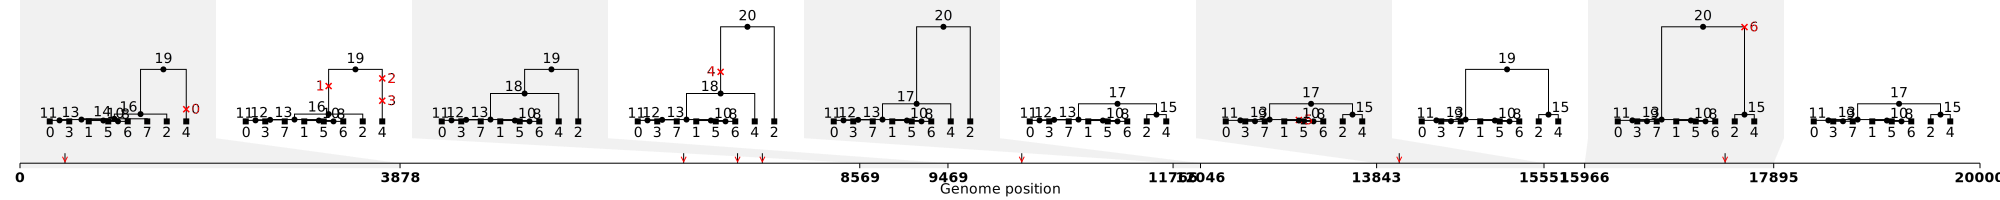

In [43]:
SVG(mts.draw_svg())

In [44]:
dods = [tree.as_dict_of_dicts() for tree in ts.trees()]
tree_graphs = [nx.Graph(dod) for dod in dods]
edge_pairs = [list(tree_graph.edges) for tree_graph in tree_graphs]
edge_pairs_backwards = [[(b, a) for (a, b) in sublist] for sublist in edge_pairs]
senders = [np.array([a for (a, b) in sublist]) for sublist in edge_pairs_backwards]
receivers = [np.array([b for (a, b) in sublist]) for sublist in edge_pairs_backwards]


In [45]:
def diff_spr(t1, t2):
    assert t1.num_samples() == t2.num_samples()
    nodes = set(range(t1.num_samples()))
    while nodes:
        x = nodes.pop()
        p1, p2 = [t.get_parent(x) for t in [t1, t2]]
        if p1 != p2:
            return x
        if p1 != -1:
            nodes.add(p1)
            
def find_spr(t1, t2):
    start0 = diff_spr(t1, t2)
    deleted = t1.parent(start0)
    start1, = t1.siblings(start0)
    # the recombination could have occured either on (start0, deleted) or (start1, deleted)
    # to settle this, in t2, one of them will have the same grandparent and the other wont
    gp = t1.parent(deleted)
    gp0 = t2.parent(start0)
    gp1 = t2.parent(start1)
    start = start1 if gp0 == gp else start0
    end, = t2.siblings(start)
    if t1.parent(end) == tskit.NULL:
        x = t2.time(t2.parent(end)) - t2.time(end)
        root = True
    else:
        t0 = t1.time(t1.parent(end)) - t1.time(end)
        t1 = t2.time(t2.parent(end)) - t2.time(end)
        x = t1 / t0
        root = False
    return (start, deleted)

In [46]:
true_edges = [find_spr(t1, t2) for t1, t2 in it.pairwise(ts.aslist())]
true_edge_indices = [sublist.index(edge) for edge, sublist in zip(true_edges, edge_pairs_backwards)]

In [47]:
true_edge_indices

[4, 3, 0, 2, 0, 11, 0, 0, 0]

In [48]:
# take a matrix of just the kept columns and expand with zeroes everywhere else for a fixed range of the full matrix.
def restore_and_slice(X, start, end, kept_cols):
  n = X.shape[0]
  n_cols = int(end - start)

  full_sub = np.zeros((n, n_cols))

  for idx, col in enumerate(kept_cols):
    if start <= col < end:
      full_sub[:, int(col-start)] = X[:, idx]

  return full_sub

# do this for the genotype matrix
def make_genotype_windows(G, tree_num, breakpoints, mutation_sites):
  start_site = breakpoints[tree_num+1]
  end_site = breakpoints[tree_num + 2]

  start_genotype = start_site
  if end_site < (start_site + 100):
    end_genotype = end_site
  else:
    end_genotype = start_site + 100
  
  G_sub = restore_and_slice(X=G, start = start_genotype, end = end_genotype, kept_cols=mutation_sites)
  
  return G_sub

In [49]:
genotypes = [
    make_genotype_windows(
        G=sparse_genotype,
        tree_num=i,
        breakpoints=breakpoints,
        mutation_sites=mutation_sites
    )
    for i in range(len(breakpoints) - 2)  # number of trees
]
genotypes_compressed = [G.sum(axis = 1) for G in genotypes]

In [50]:
genotypes_compressed

[array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0., 0., 0., 0., 0., 0., 0., 0.])]

In [51]:
seg_sites_before_after = []
for point in breakpoints[1:-1]:
  idx = bisect.bisect_left(mutation_sites, point)
  start = max(0, idx - 3)
  end = min(len(mutation_sites), idx + 3)

  sites = mutation_sites[start:end]
  indicators = [mutation_sites.index(site) for site in sites]

  pad_left = (3 - (idx - start)) if idx - start < 3 else 0
  pad_right = (3 - (end - idx)) if end - idx < 3 else 0

  geno_slice = sparse_genotype[:, indicators]

  if pad_left > 0:
        geno_slice = np.hstack([np.zeros((geno_slice.shape[0], pad_left)), geno_slice])
  if pad_right > 0:
        geno_slice = np.hstack([geno_slice, np.zeros((geno_slice.shape[0], pad_right))])

  seg_sites_before_after.append(geno_slice)

In [52]:
init_feats = [np.column_stack((M, v)) for M, v in zip(seg_sites_before_after, genotypes_compressed)]
init_feats

[array([[0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 1., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0.]]),
 array([[1., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 0., 0., 1., 0.],
        [1., 0., 0., 1., 0., 0., 0.],
        [0., 1., 1., 1., 0., 1., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 1., 0., 0.],
        [1., 0., 0., 1., 0., 0., 0.]]),
 array([[0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0., 0.],
      

In [53]:
class InitMLP:
  def __init__(self, input_dim, hidden_dim, num_hidden, output_dim, key):
    self.params = []
    keys = jax.random.split(key, num_hidden + 1)

    last_dim = input_dim
    for i, k in enumerate(keys[: -1]):
      W = jax.random.normal(k, (last_dim, hidden_dim)) / nmp.sqrt(last_dim)
      b = jax.random.normal(k, hidden_dim) / nmp.sqrt(num_hidden)
      self.params.append((W, b))
      last_dim = hidden_dim
    
    W = jax.random.normal(keys[-1], (output_dim, last_dim)) / nmp.sqrt(output_dim)
    b = jax.random.normal(keys[-1], output_dim)
    self.params.append((W, b))
  
  def __call__(self, X):
    h = X
    for (W, b) in self.params[:-1]:
      h = jax.nn.relu(h @ W + b)
    W, b = self.params[-1]
    return h @ W + b

key = jax.random.PRNGKey(1997)
init_embedder = InitMLP(input_dim=7, hidden_dim=64, num_hidden=2, output_dim=64, key=key)

In [54]:
init_embeds = []
for G in init_feats:
  x = nmp.array(G, dtype=nmp.float32)
  z = init_embedder(x)
  init_embeds.append(z)

In [55]:
N = max([max(tree_graph.nodes) for tree_graph in tree_graphs]) + 1

In [56]:
embeddings = []
for G in init_embeds:
  embeddings_add = np.zeros((N, 64))
  embeddings_add[:init_embeds[0].shape[0], :] = G
  embeddings.append(embeddings_add)

In [57]:
tree_posts = [list(tree.nodes(order = "postorder")) for tree in ts.aslist()][:-1]

In [58]:
for tree, postorder, tree_embed in zip(ts.aslist()[:-1], tree_posts, embeddings):
    for t in postorder:
        children = tree.children(u=t)
        if children != ():
            children_vectors = tree_embed[np.array(children)]
            children_mean = np.mean(children_vectors, axis=0)
            tree_embed[t] = children_mean

In [59]:
class MLPMessageLayer(eqx.Module):
  phi: eqx.nn.MLP
  gamma: eqx.nn.MLP

  def __init__(self, in_dim, hidden_dim = 64, *, key):
    k1, k2 = jax.random.split(key)

    self.phi = eqx.nn.MLP(
      in_size=2 * in_dim, # (features of the node and its neighbor)
      out_size= hidden_dim,
      width_size= hidden_dim,
      depth = 2,
      activation=jax.nn.relu,
      final_activation=jax.nn.relu,
      key = k1
    )

    self.gamma = eqx.nn.MLP(
      in_size=in_dim + hidden_dim,
      out_size=hidden_dim,
      width_size=hidden_dim,
      depth=2,
      activation=jax.nn.relu,
      key=k2
    )

  def __call__(self, X, senders, receivers):
    """
    X: [N, D] node features
    senders: [E] edge source indices
    receivers: [E] edge target indices
    """
    # gather features
    X_j = X[senders]
    X_i = X[receivers]


    m_ji = jax.vmap(self.phi)(nmp.concatenate([X_i, X_j], axis=-1))

    # aggregate by mean
    N = X.shape[0]
    m_sum = jax.ops.segment_sum(m_ji, receivers, N)
    deg = jax.ops.segment_sum(nmp.ones_like(receivers), receivers, N)
    deg = nmp.maximum(deg, 1)[:, None]
    m_i = m_sum / deg

    return jax.vmap(self.gamma)(nmp.concatenate([X, m_i], axis=-1))

class MPNNEncoder(eqx.Module):
  layers: list

  def __init__(self, in_dim, hidden_dim, num_layers, *, key):
    keys = jax.random.split(key, num_layers)
    self.layers = [MLPMessageLayer(in_dim, hidden_dim, key=keys[0])]
    for k in keys[1:]:
      self.layers.append(MLPMessageLayer(hidden_dim, hidden_dim, key = k))
  
  def __call__(self, X, senders, receivers):
    for layer in self.layers:
      X = layer(X, senders, receivers)
    return X

class SPRGPredictor(eqx.Module):
  encoder: MPNNEncoder
  head: eqx.nn.MLP

  def __init__(self, in_dim, hidden_dim, num_layers, *, key):
    k_enc, k_head = jax.random.split(key)
    self.encoder = MPNNEncoder(in_dim, hidden_dim, num_layers, key = k_enc)
    self.head = eqx.nn.MLP(
      in_size = 2*hidden_dim,
      out_size= 1, # this will be whole edge prediction, where it starts, where it ends. Right now, we are doing logit prediction for all possib  le edge starts, so the cardinality of this set will be E.
      width_size=hidden_dim,
      depth=2,
      activation=jax.nn.relu,
      key = k_head
    )
  
  def __call__(self, X, senders, receivers):
    H = self.encoder(X, senders, receivers)
    # jax.debug.print("embeddigns = {}", H)
    h_i, h_j = H[receivers], H[senders]
    logits = jax.vmap(self.head)(nmp.concatenate([h_i, h_j], axis=-1)).squeeze(-1)
    return logits

In [60]:
def nll(logits, target_edge_idx: int):
    log_probs = logits - jax.nn.logsumexp(logits)     # log probabilites
    return -log_probs[target_edge_idx] # minimize the negative log probability of the correct edge change == maximize predicted log probabiliy of the correct edge change

In [61]:
@eqx.filter_value_and_grad
def loss_fn(model, X_batch, senders_batch, receivers_batch, targets_batch):
  losses = []
  for X, s, r, t in zip(X_batch, senders_batch, receivers_batch, targets_batch):
    logits = model(X, s, r)
    losses.append(nll(logits, t))
  
  return nmp.mean(nmp.stack(losses))

@eqx.filter_jit
def train_step(model, opt_state, X_batch, senders_batch, receivers_batch, targets_batch, optim):
  loss, grads = loss_fn(model, X_batch, senders_batch, receivers_batch, targets_batch)
  updates, opt_state = optim.update(grads, opt_state, params = eqx.filter(model, eqx.is_array))
  model = eqx.apply_updates(model, updates)
  
  return model, opt_state, loss

model = SPRGPredictor(in_dim=embeddings[0].shape[1], hidden_dim=32, num_layers=3, key=key)
optim = optax.adam(1e-3)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

In [62]:
for step in range(301):
  model, opt_state, loss = train_step(model, opt_state, embeddings, senders[:-1], receivers[:-1], true_edge_indices, optim)
  if step % 50 == 0:
    print(f"step {step:03d} | loss {loss:.4f}")
    logits = model(embeddings[0], senders[0], receivers[0])
    probs = jax.nn.softmax(logits)
    print(f"top edge (graph 0): {nmp.argmax(probs)}")

step 000 | loss 2.6391
top edge (graph 0): 1
step 050 | loss 2.3864
top edge (graph 0): 0
step 100 | loss 1.1864
top edge (graph 0): 0
step 150 | loss 1.0565
top edge (graph 0): 0
step 200 | loss 0.6228
top edge (graph 0): 4
step 250 | loss 0.4848
top edge (graph 0): 4
step 300 | loss 0.4747
top edge (graph 0): 4


In [63]:
for i, (X, s, r) in enumerate(zip(embeddings, senders[:-1], receivers[:-1])):
    logits = model(X, s, r)
    edge_idx = int(nmp.argmax(logits))
    probs = np.exp(logits) / np.sum(np.exp(logits))
    print(f"graph {i}: predicted edge index = {edge_idx}")
    print(f"graph {i}: probs = {probs}")

graph 0: predicted edge index = 4
graph 0: probs = [2.3046113e-03 0.0000000e+00 2.5324821e-01 0.0000000e+00 2.7187219e-01
 0.0000000e+00 6.2253105e-40 1.4855039e-32 2.3642842e-01 3.2243482e-36
 5.9036627e-02 5.9036627e-02 5.9036627e-02 5.9036627e-02]
graph 1: predicted edge index = 3
graph 1: probs = [1.0509065e-36 2.0796326e-03 1.6345776e-08 9.9792010e-01 9.9357420e-16
 4.3694039e-34 7.1333605e-16 1.0131124e-23 1.4221943e-07 1.4221943e-07
 2.8634242e-21 2.7388995e-32 2.2192557e-13 2.2192557e-13]
graph 2: predicted edge index = 0
graph 2: probs = [9.2142069e-01 1.6656358e-02 5.2569432e-40 6.1922379e-02 2.3566193e-15
 1.0363616e-33 1.6919336e-15 2.4029614e-23 3.3732468e-07 3.3732468e-07
 6.7916432e-21 6.4962872e-32 5.2637652e-13 5.2637652e-13]
graph 3: predicted edge index = 2
graph 3: probs = [3.8380590e-01 5.8294652e-32 4.9817675e-01 0.0000000e+00 0.0000000e+00
 2.1262313e-22 2.3241486e-05 1.2611686e-44 6.1603191e-06 6.1603191e-06
 1.0265608e-02 1.8420646e-24 5.3858113e-02 5.3858113e-

In [64]:
true_edge_indices

[4, 3, 0, 2, 0, 11, 0, 0, 0]